In [1]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser

# Data viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to C:\Users\Sanchit
[nltk_data]     Tomar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sanchit
[nltk_data]     Tomar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = #Your_API_Key

In [3]:
channel_ids = ['UCVYamHliCI9rw1tHR1xbkfw'
              #More Channel Id
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client

youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

def get_video_ids(youtube,playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId = playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token= response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token= response.get('nextPageToken')
    
    return video_ids

def get_video_details(youtube,video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']}
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_stats = get_channel_stats(youtube,channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Dave2D,3550000,701760795,671,UUVYamHliCI9rw1tHR1xbkfw


In [8]:
playlist_id = "UUVYamHliCI9rw1tHR1xbkfw"

In [9]:
# Get video IDs
video_ids = get_video_ids(youtube,playlist_id)

In [10]:
len(video_ids)

671

In [11]:
# Get video details
video_df = get_video_details(youtube,video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption
0,IqHO9k0fcZo,Dave2D,Nothing Phone Exposed,Nothing Phone review will come soon but lets d...,"[Dave2D, Review, nothing phone, phone(1), tear...",2022-07-15T07:01:12Z,514982,29993,0,1532,PT4M4S,hd,false
1,gqYaqBVT5vM,Dave2D,M2 MacBook Air Review - Needs More Air,2022 MacBook Air Review with the M2 Chip with ...,"[Dave2D, Review, 2022, m2 macbook air, versus ...",2022-07-14T13:07:23Z,700535,29783,0,1704,PT8M4S,hd,false
2,fKoDe6kw_ZE,Dave2D,Before You Buy an AMD Gaming Laptop...,AMD Advantage Laptops\n\nIf you want to suppor...,"[Dave2D, Review, amd advantage, best gaming la...",2022-07-13T17:26:00Z,387497,24438,0,1004,PT8M39S,hd,false
3,krnZUfixffY,Dave2D,Apple's New iPhone Trick Seems Impossible,iOS 16 Continuity Camera is WILD. You need an ...,"[Dave2D, Review, iOS 16, ios16, macOS ventura,...",2022-07-11T18:28:08Z,487962,24991,0,1526,PT5M52S,hd,false
4,OsQymqWRu6Y,Dave2D,Razer vs Alienware Gaming Laptops,My review of the 2022 Alienware X17 X15 and X1...,"[Dave2D, Review]",2022-07-09T17:34:07Z,493501,24599,0,1566,PT8M33S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,5P5QwVlB2kg,Dave2D,Update No. 1 - Dell Venue 8 7840 Giveaway,Just a quick update while I work on some more ...,"[giveaway, Dave2d, dell venue, Contest, Androi...",2015-01-26T22:41:32Z,10857,304,0,54,PT2M15S,hd,false
667,XnFh3s74Dxg,Dave2D,Dell XPS 13 Review - 2015,A really comprehensive review of the 2015 Dell...,"[Dell (Computer Manufacturer/Brand), Dell XPS ...",2015-01-21T04:04:53Z,266167,3223,0,552,PT11M17S,hd,false
668,qL4vZjhwJsk,Dave2D,Using old SD Cards on the Panasonic GH4!,Short video to clear up any confusion as to wh...,"[Panasonic GH4, GH4, SD CARD, SD, Review, Secu...",2015-01-15T20:40:14Z,11292,209,0,22,PT1M40S,hd,false
669,0NOcojVOgeI,Dave2D,Dell Venue 8 7000 Review,My first review. Hope you guys like it!\n\nThe...,"[Dell venue, 7000, Tablet, ipad, android, loll...",2015-01-15T02:37:11Z,56332,866,0,138,PT4M31S,hd,false


## Data Pre-Processing

In [12]:
# Check for NULL values
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
viewCount        False
likeCount        False
favoriteCount    False
commentCount     False
duration         False
definition       False
caption          False
dtype: bool

In [13]:
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
definition       object
caption          object
dtype: object

In [14]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [15]:
# Publish Day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [16]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [17]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,244.0,PT4M4S
1,484.0,PT8M4S
2,519.0,PT8M39S
3,352.0,PT5M52S
4,513.0,PT8M33S
...,...,...
666,135.0,PT2M15S
667,677.0,PT11M17S
668,100.0,PT1M40S
669,271.0,PT4M31S


In [18]:
# Add Tag Count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [19]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,IqHO9k0fcZo,Dave2D,Nothing Phone Exposed,Nothing Phone review will come soon but lets d...,"[Dave2D, Review, nothing phone, phone(1), tear...",2022-07-15 07:01:12+00:00,514982,29993,0,1532,PT4M4S,hd,false,Friday,244.0,9
1,gqYaqBVT5vM,Dave2D,M2 MacBook Air Review - Needs More Air,2022 MacBook Air Review with the M2 Chip with ...,"[Dave2D, Review, 2022, m2 macbook air, versus ...",2022-07-14 13:07:23+00:00,700535,29783,0,1704,PT8M4S,hd,false,Thursday,484.0,6
2,fKoDe6kw_ZE,Dave2D,Before You Buy an AMD Gaming Laptop...,AMD Advantage Laptops\n\nIf you want to suppor...,"[Dave2D, Review, amd advantage, best gaming la...",2022-07-13 17:26:00+00:00,387497,24438,0,1004,PT8M39S,hd,false,Wednesday,519.0,8
3,krnZUfixffY,Dave2D,Apple's New iPhone Trick Seems Impossible,iOS 16 Continuity Camera is WILD. You need an ...,"[Dave2D, Review, iOS 16, ios16, macOS ventura,...",2022-07-11 18:28:08+00:00,487962,24991,0,1526,PT5M52S,hd,false,Monday,352.0,8
4,OsQymqWRu6Y,Dave2D,Razer vs Alienware Gaming Laptops,My review of the 2022 Alienware X17 X15 and X1...,"[Dave2D, Review]",2022-07-09 17:34:07+00:00,493501,24599,0,1566,PT8M33S,hd,false,Saturday,513.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,5P5QwVlB2kg,Dave2D,Update No. 1 - Dell Venue 8 7840 Giveaway,Just a quick update while I work on some more ...,"[giveaway, Dave2d, dell venue, Contest, Androi...",2015-01-26 22:41:32+00:00,10857,304,0,54,PT2M15S,hd,false,Monday,135.0,9
667,XnFh3s74Dxg,Dave2D,Dell XPS 13 Review - 2015,A really comprehensive review of the 2015 Dell...,"[Dell (Computer Manufacturer/Brand), Dell XPS ...",2015-01-21 04:04:53+00:00,266167,3223,0,552,PT11M17S,hd,false,Wednesday,677.0,14
668,qL4vZjhwJsk,Dave2D,Using old SD Cards on the Panasonic GH4!,Short video to clear up any confusion as to wh...,"[Panasonic GH4, GH4, SD CARD, SD, Review, Secu...",2015-01-15 20:40:14+00:00,11292,209,0,22,PT1M40S,hd,false,Thursday,100.0,8
669,0NOcojVOgeI,Dave2D,Dell Venue 8 7000 Review,My first review. Hope you guys like it!\n\nThe...,"[Dell venue, 7000, Tablet, ipad, android, loll...",2015-01-15 02:37:11+00:00,56332,866,0,138,PT4M31S,hd,false,Thursday,271.0,15


## EDA

### Best Performing Videos

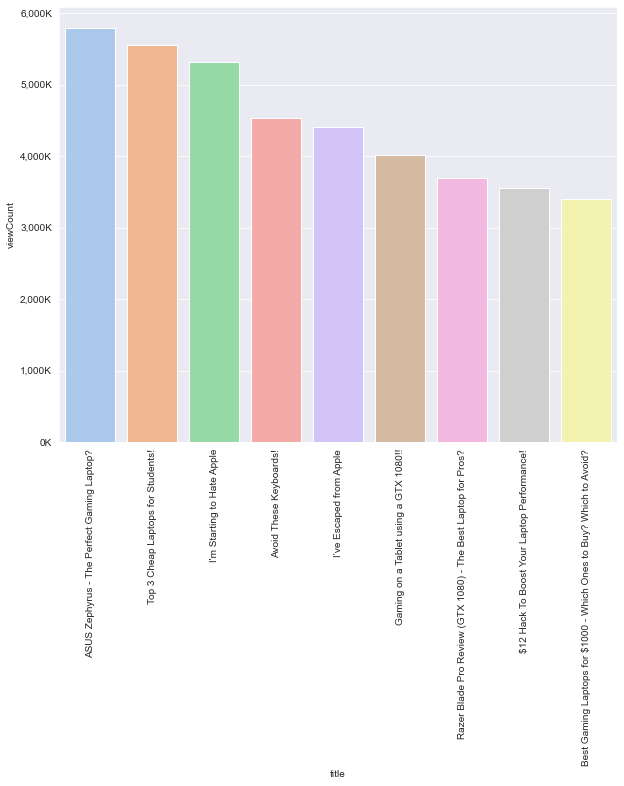

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount',ascending=False)[1:10],palette='pastel')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst Performing Videos

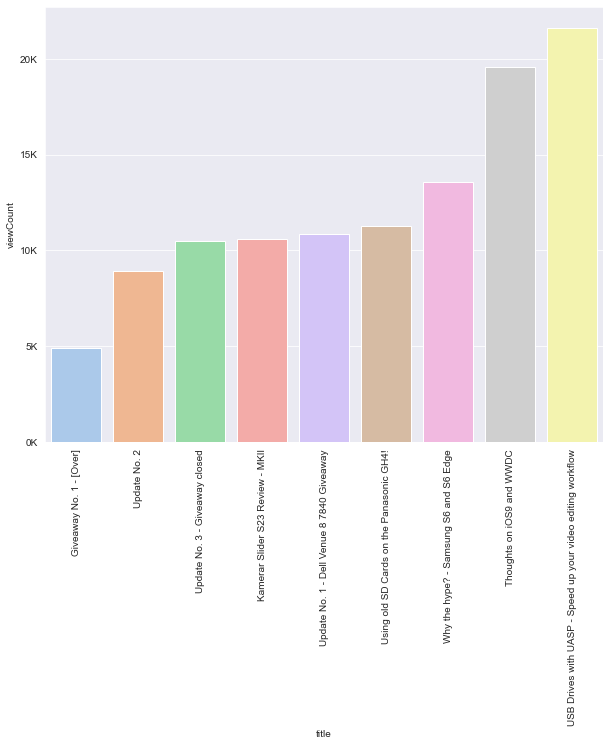

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount',ascending=True)[0:9],palette='pastel')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000) + 'K'))

### View Distribution per video

<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

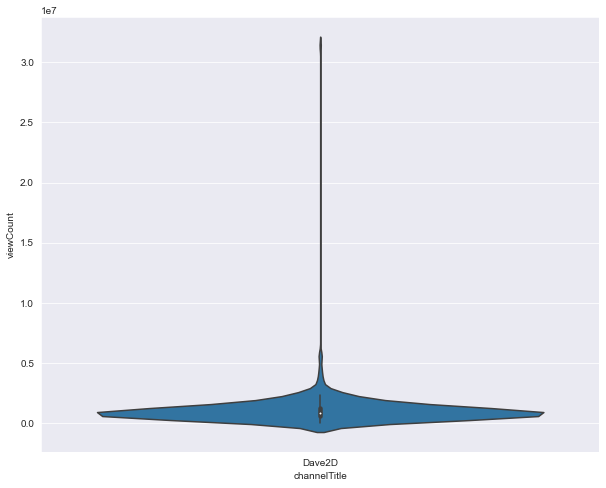

In [22]:
plt.figure(figsize=(10,8))
sns.violinplot(x='channelTitle',y='viewCount',data=video_df)

### Views vs Likes and Comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

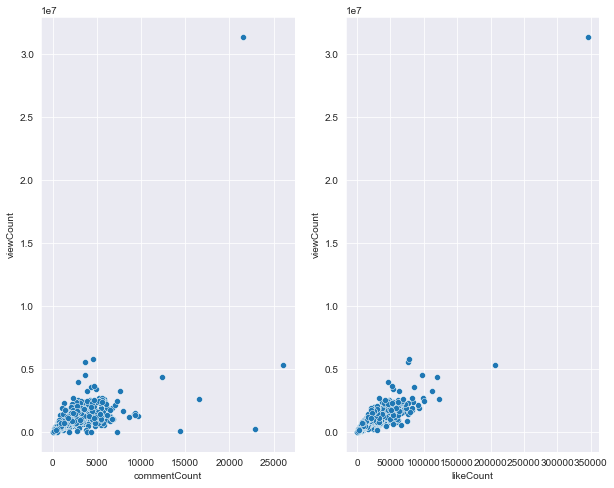

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
sns.scatterplot(data=video_df, x='commentCount', y='viewCount', ax=ax[0])
sns.scatterplot(data=video_df, x='likeCount', y='viewCount', ax=ax[1])

### Video Duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

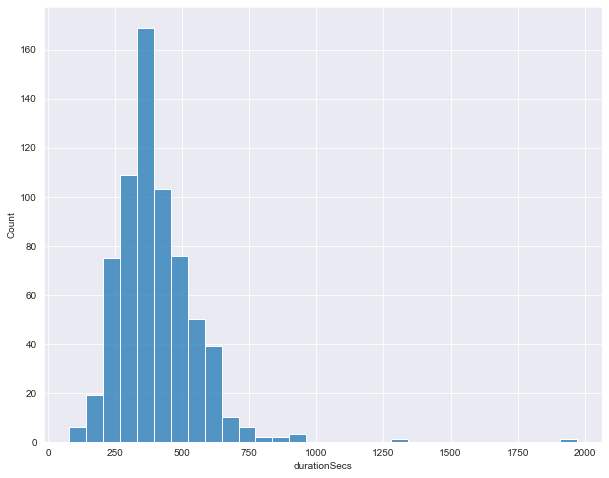

In [24]:
plt.figure(figsize=(10,8))
sns.histplot(data=video_df, x='durationSecs', bins=30)

### Wordcloud for video titles

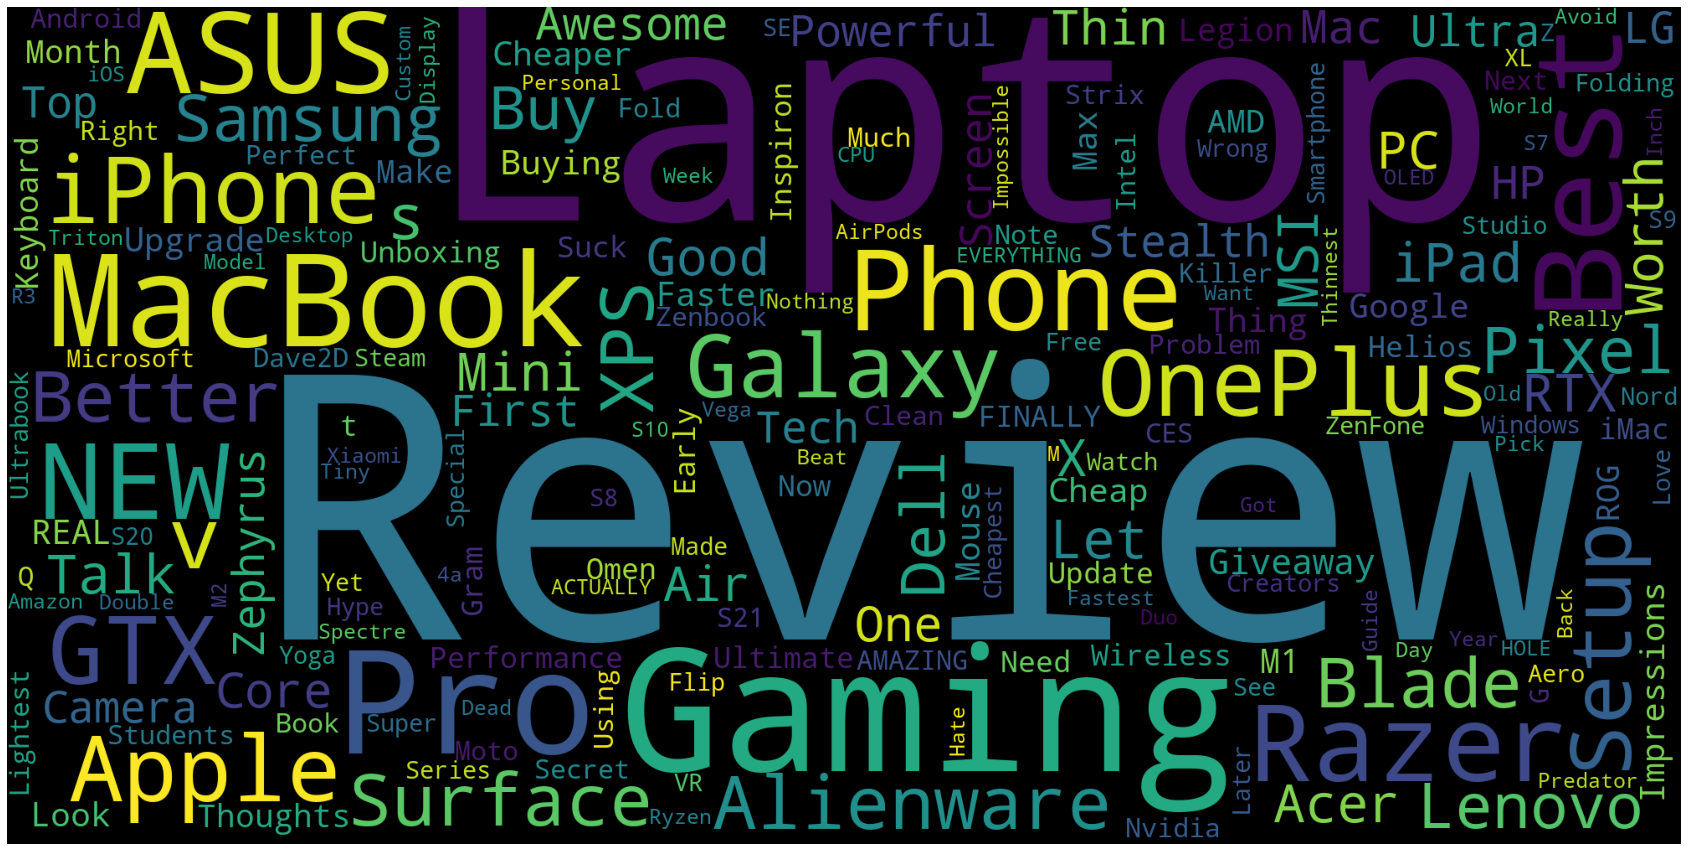

In [25]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload Schedule

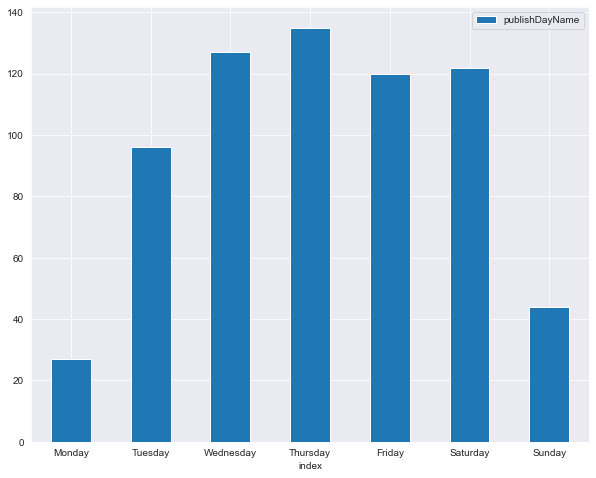

In [26]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0, figsize=(10,8))